# Split datasets into sequences and plot them
* [UCR data](http://localhost:8888/notebooks/datasets/explore_datasets.ipynb#UCR-data)
* [Synthetic data](http://localhost:8888/notebooks/datasets/explore_datasets.ipynb#Synthetic-data)
* [UCI data](http://localhost:8888/notebooks/datasets/explore_datasets.ipynb#UCI-data)
* [Artificial data](http://localhost:8888/notebooks/datasets/explore_datasets.ipynb#Artificial-data)
* [Sensortag data](http://localhost:8888/notebooks/datasets/explore_datasets.ipynb#Sensortag-data)

# Helper functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches, colors
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Debugger
from IPython.core.debugger import Pdb
t = Pdb().set_trace

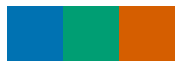

In [3]:
# Seaborn settings for nice plots
sns.set_style('dark')
colors_example = sns.color_palette('colorblind', 3)
sns.palplot(colors_example)

In [4]:
# Utility functions to generate time series data
np.random.seed(22)

def generate_data(period, num_series, num_points, var):
    t = np.linspace(0, num_points/2, num_points)
    random_means = np.random.rand(num_series, num_points) # a random mean for each serie
    random_var = var * np.random.randn(num_series, 1)
    data = random_means + random_var + np.sin(t * period)
    return data
    

def generate_series(num_labels, num_series_per_label, num_points_per_series):
    var = 0.5
    dfs = []
    for label in range(num_labels):
        period = label + 1
        data = generate_data(period, num_series_per_label, num_points_per_series, var)
        df = pd.DataFrame(data=data, columns=['t%s' % i for i in range(len(data[0]))])
        labels = np.zeros(num_series_per_label, dtype=int)
        labels.fill(label)
        df['label'] = labels
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
class OffsetTooLargeException(Exception):
    pass
    
# Utility function to reshape a dataframe
def reshape_df(df, max_rows, max_columns, row_offset=0, col_offset=0):
    if max_columns is not None:
        max_col_offset = len(df.columns.values) - (max_columns-1)
        if col_offset > max_col_offset:
            raise OffsetTooLargeException('Column offset should be lower than %s' %max_col_offset)
        columns = list(df.columns.values)[col_offset:col_offset+(max_columns-1)]
        if 'label' not in columns: columns.append('label')
        df = df.loc[:, columns]
    
    if max_rows is not None:
        max_row_offset = len(df) - max_rows
        if row_offset > max_row_offset:
            raise OffsetTooLargeException('Row offset should be lower than %s' %max_row_offset)
        df = df.iloc[row_offset:row_offset+max_rows]
    return df

In [6]:
# Utility function to plot groups of time series
def plot_df(df, title=None, size=1, ymin=None, ymax=None):
    
    label_names = df.label.unique()
    for label in label_names:
        data = df.loc[df.label==label, df.columns.values != 'label'].values
            
        if len(data) == 1: # If there is only one time series, there's no point to plot uncertainty across series.
            plot_uncertainty = False
        else:
            plot_uncertainty = True
        
        if plot_uncertainty:
            f, ax = plt.subplots(2, figsize=(20,5 * size))
            # Plot all series
            for series in data:
                ax[0].plot(series)
            ax[0].set_xlim(0, len(series) -1)

            # Show variance / uncertainty across all series 
            sns.tsplot(data=data, ax=ax[1])
            if ymin is not None and ymax is not None:
                ax[0].set_ylim(ymin, ymax)
                ax[1].set_ylim(ymin, ymax)
            if title is not None:
                ax[0].set_ylabel(title)
                ax[1].set_ylabel('var(%s)' % title)
        else:
            f, ax = plt.subplots(1, figsize=(20,5 * size))

            # Plot all series
            for series in data:
                ax.plot(series)
            ax.set_xlim(0, len(series) -1)
            if ymin is not None and ymax is not None:
                ax.set_ylim(ymin, ymax)
            if title is not None:
                ax.set_ylabel(title)



# Utility functions plot timeseries with color patches.
# Useful for timeseries with labels.
# Note on how to draw rectangles with mpl: http://matthiaseisen.com/pp/patterns/p0203 
def plot_df_labels(df, name):
    """
    Plot data, hihglight each label in different colors, and add a legend.
    
    :param df: (pd.DataFrame) data to plot. Must contain a 'label' column.
    :param name: (str) name of the plot.
    """
    # Label IDs and color palette
    label_names = sorted(df.label.unique())
    palette = sns.color_palette('colorblind', len(label_names))  
    
    # Plot color palette legend
    plot_palette_legend(palette, label_names, 'Labels of %s' %name, alpha=0.5, size=0.5)

    # Features
    columns = list(df.columns.values)
    if 'label' in columns: columns.remove('label')
    nb_columns = len(columns)
    
    # Plot data
    fig, ax = plt.subplots(nrows=nb_columns, ncols=1, 
                           figsize=(20, nb_columns* 2))
    
    for i in range(nb_columns):
        column_name = columns[i]
        values = df[column_name].values
        labels = df.label.values
        ax[i].plot(values)
        add_patches(ax[i], values, labels, label_names, palette, alpha=0.5)
        ax[i].set_ylabel(column_name)
    plt.tight_layout()
    

def plot_palette_legend(palette, label_names, title, alpha=0.5, size=0.5):
    """
    Plot the values in a color palette as a horizontal array.

    palette: sequence of matplotlib colors as returned by seaborn.color_palette()
    size: scaling factor for size of plot
    """
    n = len(palette)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              alpha=alpha,
              cmap=colors.ListedColormap(palette),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels([])
    ax.set_title(title, loc='left')


def add_patches(ax, values, labels, label_ids, palette, alpha=0.5):
    """
    Highlight each label with different color patches.
    """
    minval = min(values)
    maxval = max(values) 
    ax.set_xlim(0, len(values)-1)
    ax.set_ylim(minval, maxval)
    
    start = 0
    curr_label = labels[0]
    # Print patches when the label changes
    for t in range(len(values)):
        label = labels[t]
        if label != curr_label:
            end = t
            color_idx = label_ids.index(curr_label)
            color = palette[color_idx]
            ax.add_patch(patches.Rectangle((start, minval), # (x, y)
                                            end-start, # width
                                            maxval-minval, # height
                                            alpha=alpha, 
                                            color=color))
            start = end
            curr_label = label

    # Print the last patch
    end = t
    color_idx = label_ids.index(curr_label)
    color = palette[color_idx]
    ax.add_patch(patches.Rectangle((start, minval), # (x, y)
                                    end-start, # width
                                    maxval-minval, # height
                                    alpha=alpha, 
                                    color=color))

In [7]:
# Util function to plot a summary of the sequences in a dataframe.
def plot_sequences(df, label_names, max_rows, max_columns, row_offset, col_offset, ymin, ymax, plot_size):
    print 'number of sequences:', len(df)
    for label in sorted(df.label.unique()):
        print 'number of sequences for label %s: %s' %(label_names[int(label)], len(df[df.label == label]))
        df2 = reshape_df(df[df.label == label], max_rows, max_columns, col_offset=col_offset, row_offset=row_offset)
        plot_df(df2, label_names[int(label)], ymin=ymin, ymax=ymax, size=plot_size)

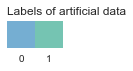

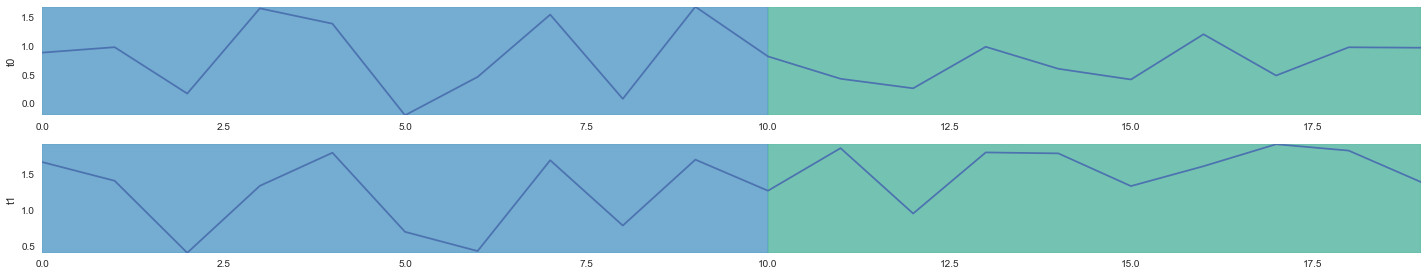

In [8]:
# Example with artificial data
num_labels = 2
num_series_per_label = 10
num_points_per_series = 20
df = generate_series(num_labels, num_series_per_label, num_points_per_series)

max_rows = None
max_columns = 3
df1 = reshape_df(df, max_rows, max_columns)
plot_df_labels(df1, 'artificial data')

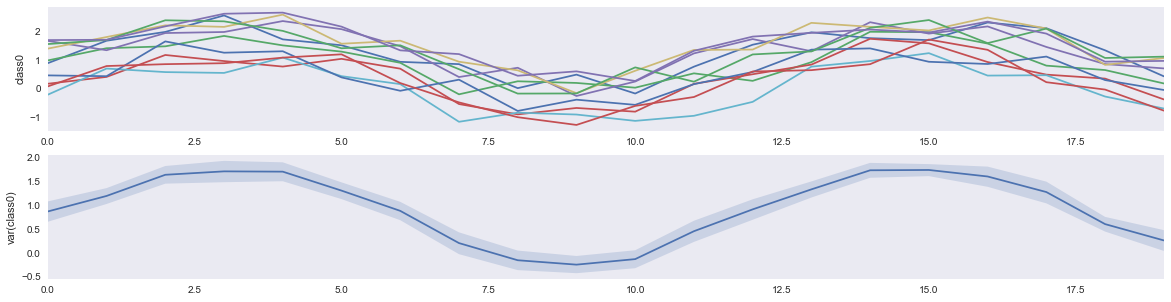

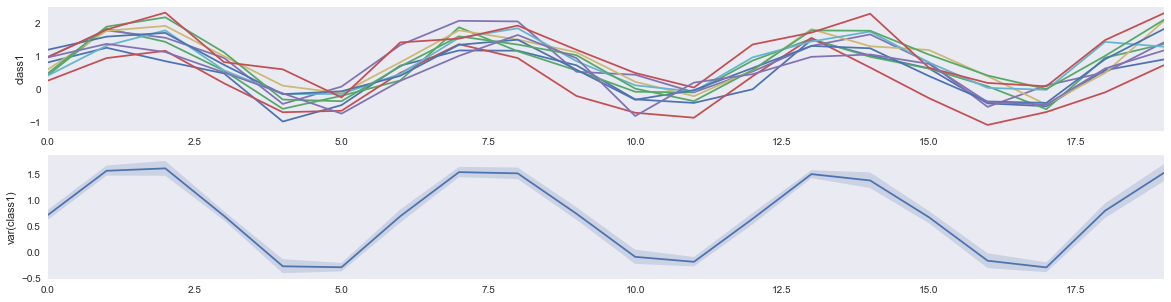

In [9]:
max_rows = 10
max_columns = None
for label in df.label.unique():
    df2 = reshape_df(df[df.label == label], max_rows, max_columns)
    plot_df(df2, title='class%s' %label)

# UCR data
* Download the zipped data [here](http://www.cs.ucr.edu/~eamonn/time_series_data/UCR_TS_Archive_2015.zip)
* Password to unzip: `attempttopredict`

In [10]:
# Util functions to load a UCR dataset
def load(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = ['label'] + ['t%s' % i for i in range(len(df.columns) - 1)]
    return df

def get_dataset_names(datasets_dir):
    dataset_names = []
    for root, dirs, files in os.walk(datasets_dir):
        for name in dirs:
            if name[0] != '.': # ignore cached files
                dataset_names.append(name)
    return dataset_names

In [11]:
# Load a UCR dataset 
phase = 'test'

datasets_dir = "UCR_TS_Archive_2015"
names = get_dataset_names(datasets_dir)
idx = names.index('50words') # 'synthetic_control'
print names
dataset_name = names[idx]
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase.upper()))
df = load(input_csv_path)

['50words', 'Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'Car', 'CBF', 'ChlorineConcentration', 'CinC_ECG_torso', 'Coffee', 'Computers', 'Cricket_X', 'Cricket_Y', 'Cricket_Z', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'FaceAll', 'FaceFour', 'FacesUCR', 'FISH', 'FordA', 'FordB', 'Gun_Point', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lighting2', 'Lighting7', 'MALLAT', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MoteStrain', 'NonInvasiveFatalECG_Thorax1', 'NonInvasiveFatalECG_Thorax2', 'OliveOil', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme', 'Plane', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'ShapeletSim', 'S

In [12]:
label_names = range(51) # 6 labels but the first label ID is 1, not 0.
max_rows = 10
max_columns = None
row_offset = 0
col_offset = 0
ymin=-2
ymax=3
plot_size = 1

number of sequences: 454
number of sequences for label 1: 57
number of sequences for label 2: 42
number of sequences for label 3: 28
number of sequences for label 4: 33
number of sequences for label 5: 25
number of sequences for label 6: 19
number of sequences for label 7: 16
number of sequences for label 8: 13
number of sequences for label 9: 13
number of sequences for label 10: 12
number of sequences for label 11: 12
number of sequences for label 12: 9


OffsetTooLargeException: Row offset should be lower than -1

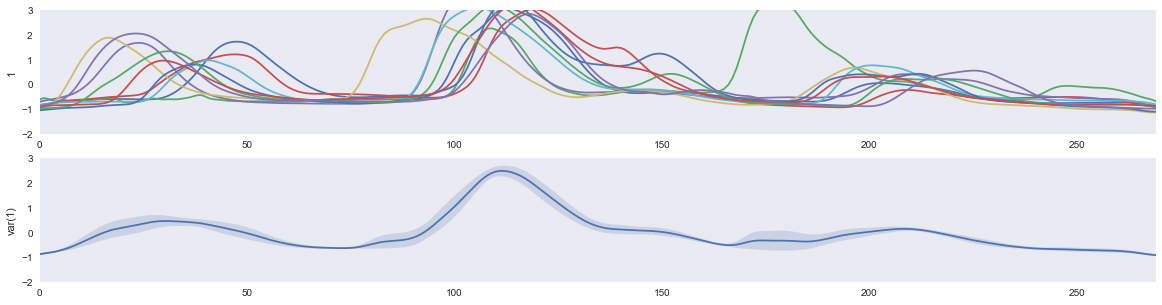

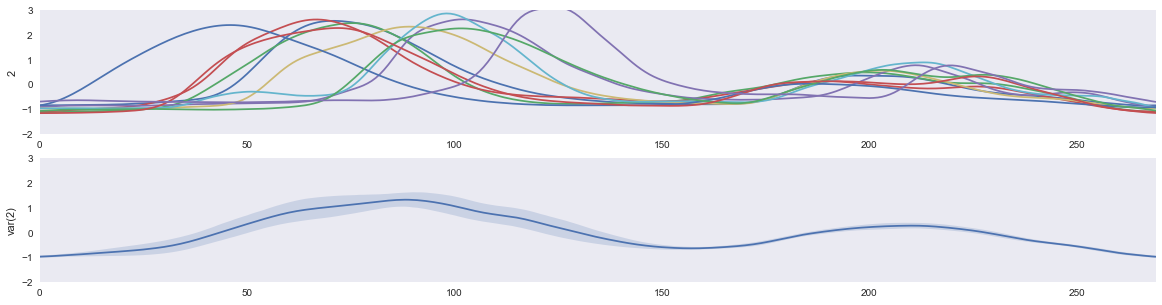

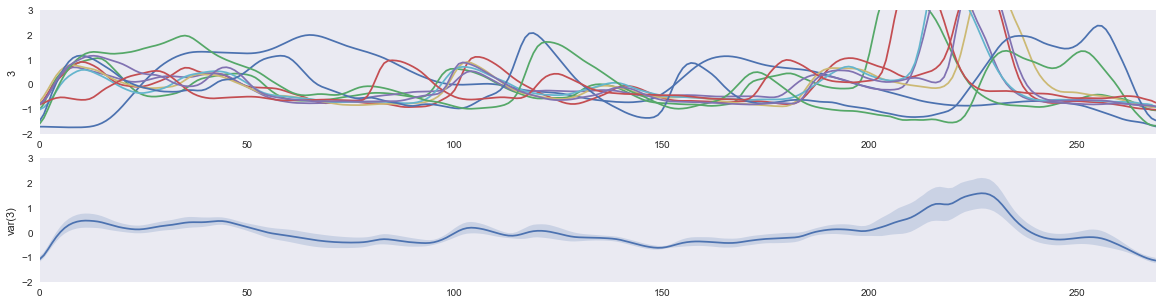

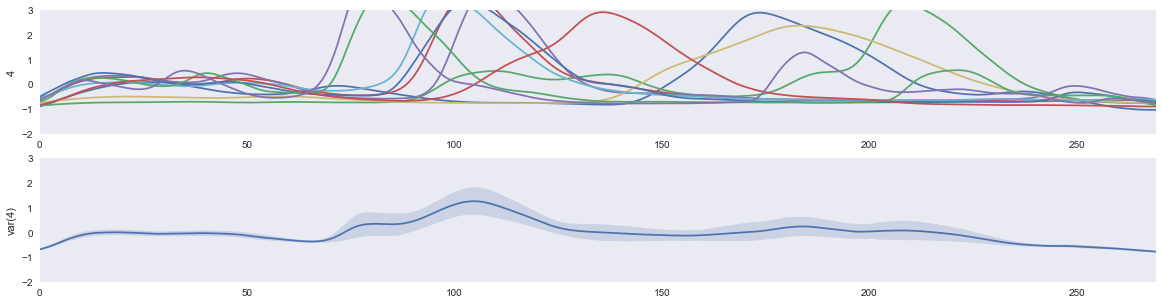

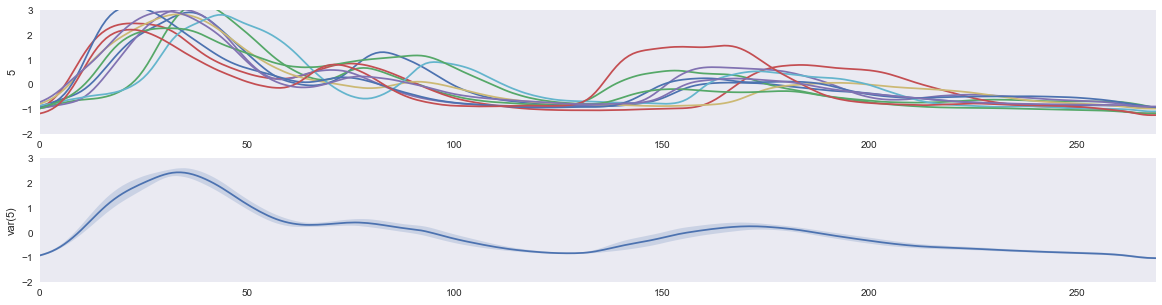

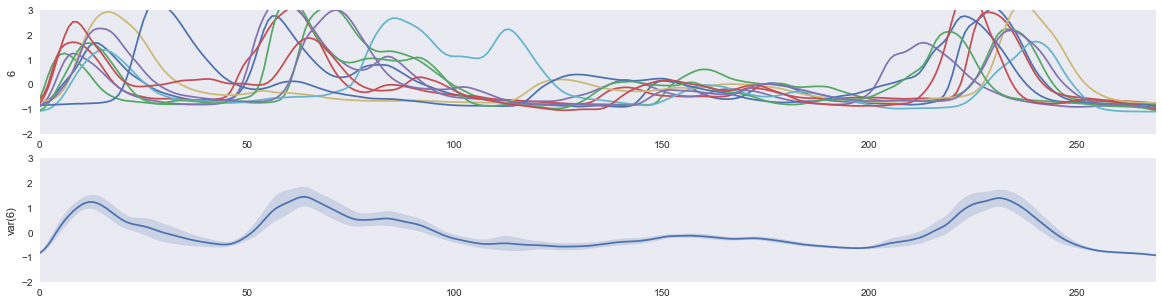

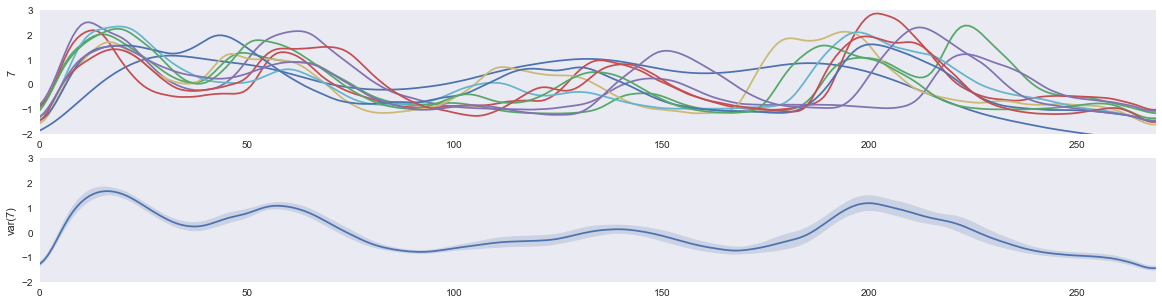

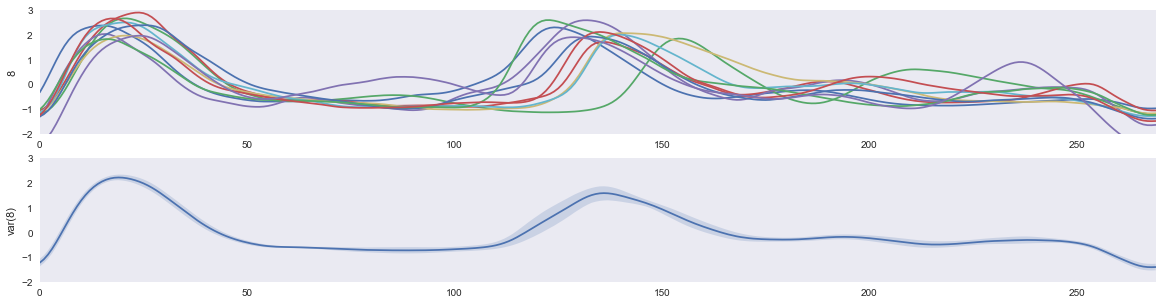

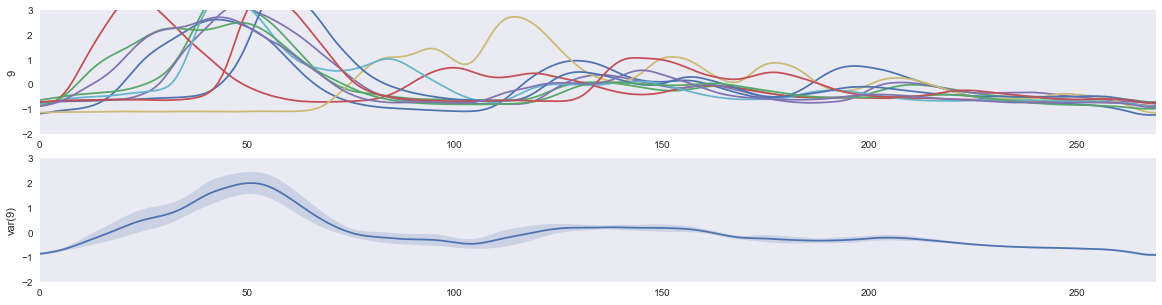

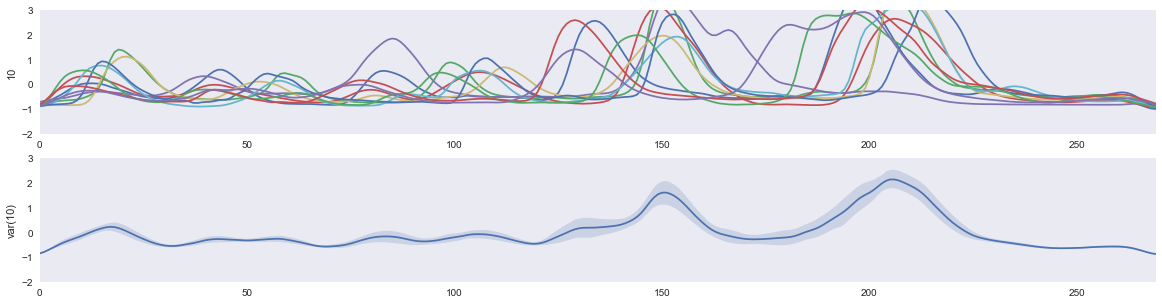

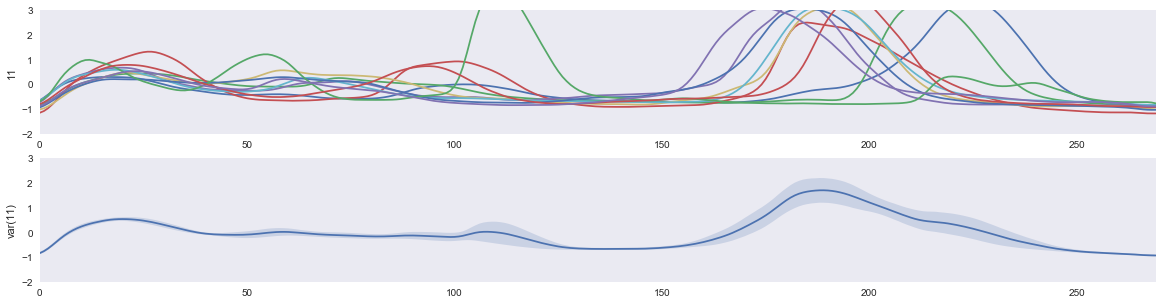

In [13]:
plot_sequences(df, label_names, max_rows, max_columns, row_offset, col_offset, ymin, ymax, plot_size)

# Synthetic data

In [46]:
!cd SyntheticData; python generate_synthetic_data.py

# Health check to make sure the values are loaded well with pandas
data = np.loadtxt(os.path.join('SyntheticData', 'Test1','Test1_TRAIN'),  delimiter=',')[1:,]

phase = 'TRAIN'
datasets_dir = "SyntheticData"
dataset_name = 'Test1'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))

df = load(input_csv_path)
assert (np.isclose(data[:,0], df[df.columns.values[0]])).all()
assert (np.isclose(data[:,1], df[df.columns.values[1]])).all()

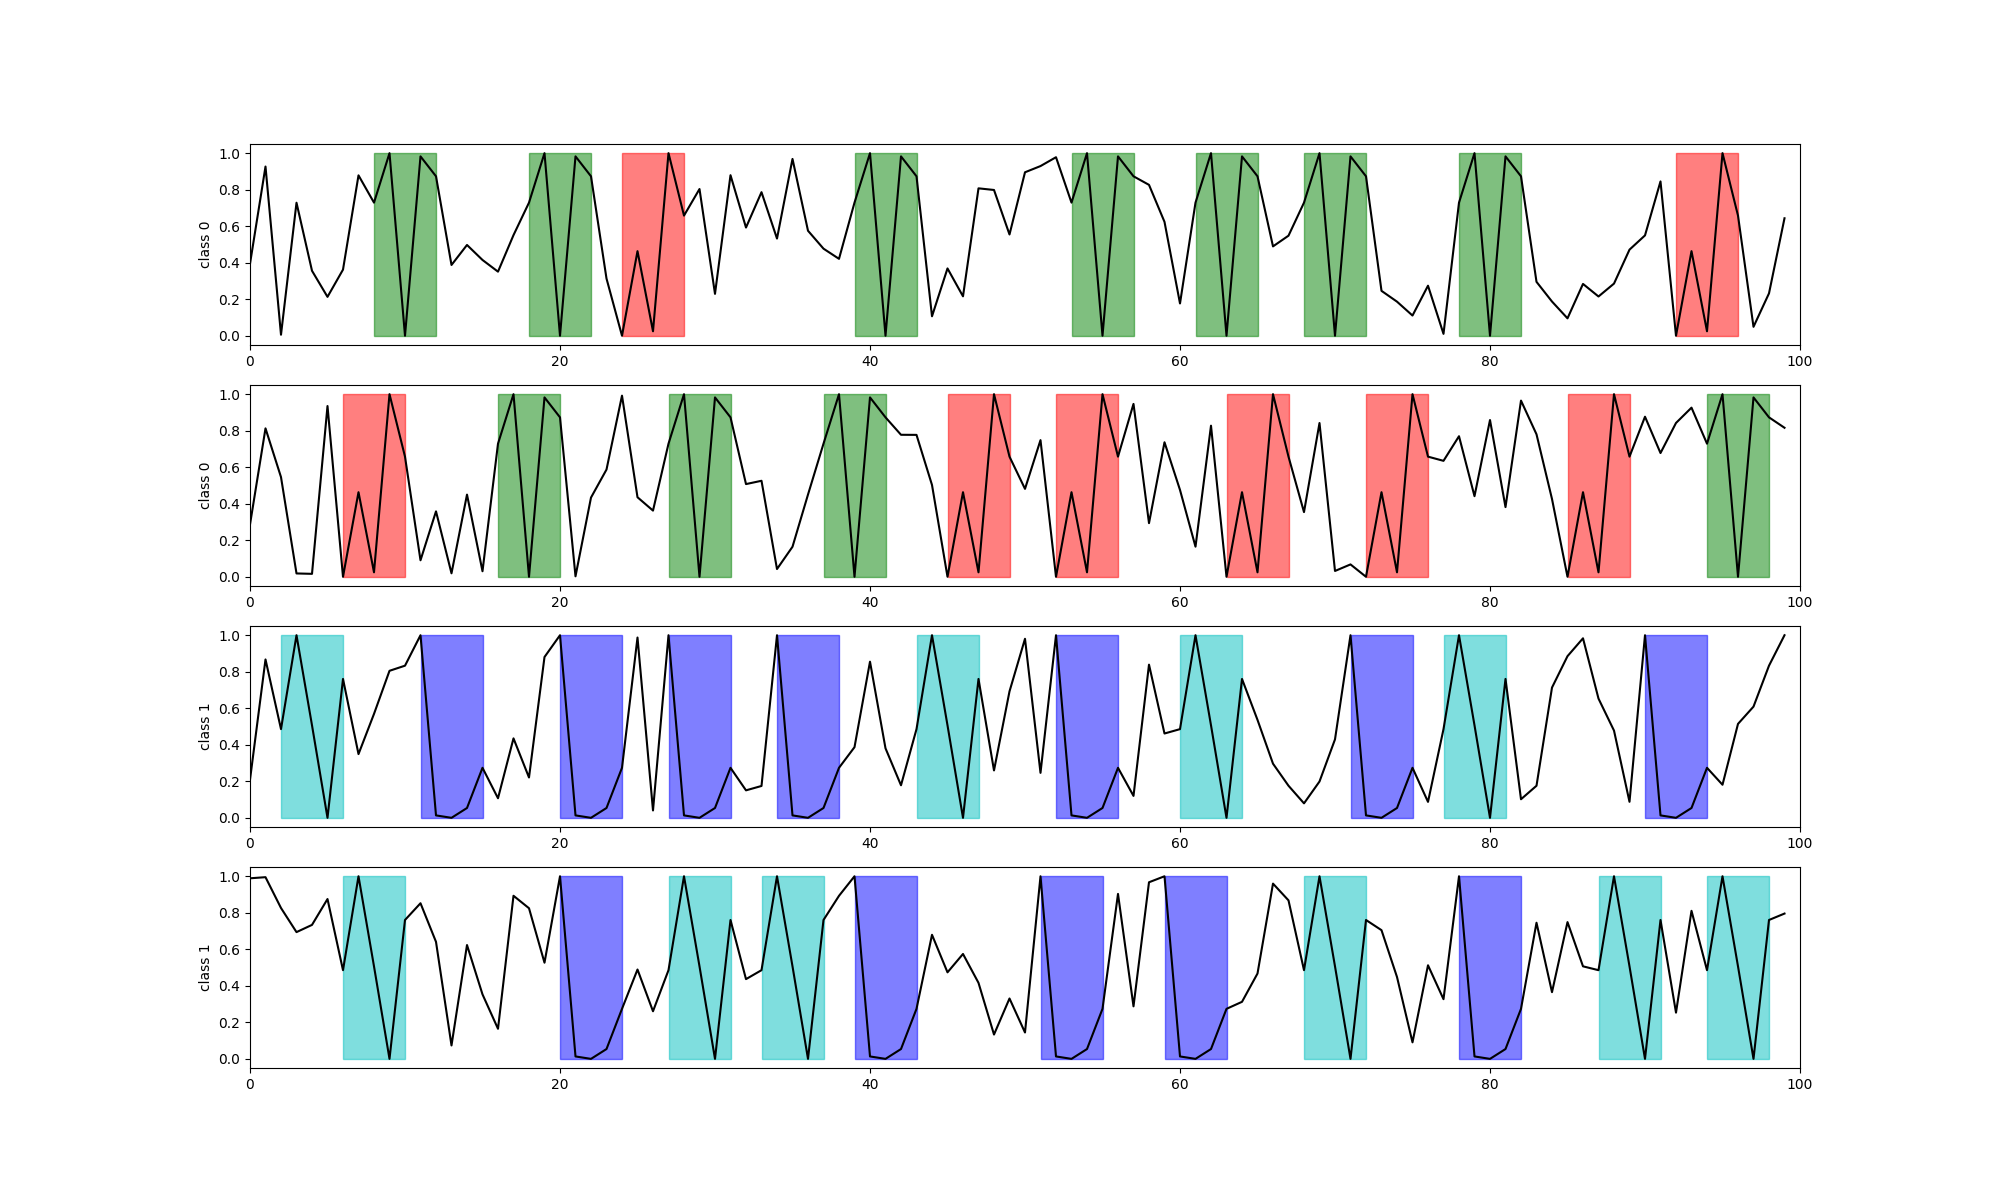

In [47]:
from IPython.display import Image, display
display(Image('SyntheticData/Test1/Test1.png'))

In [52]:
phase = 'TRAIN'
datasets_dir = "SyntheticData"
dataset_name = 'Test1'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))
df = load(input_csv_path)

label_names = range(0,2) # 2 labels
max_rows = 1
max_columns = None
row_offset = 0
col_offset = 0
ymin=0
ymax=1
plot_size = 1

number of sequences: 99
number of sequences for label 0: 49
number of sequences for label 1: 50


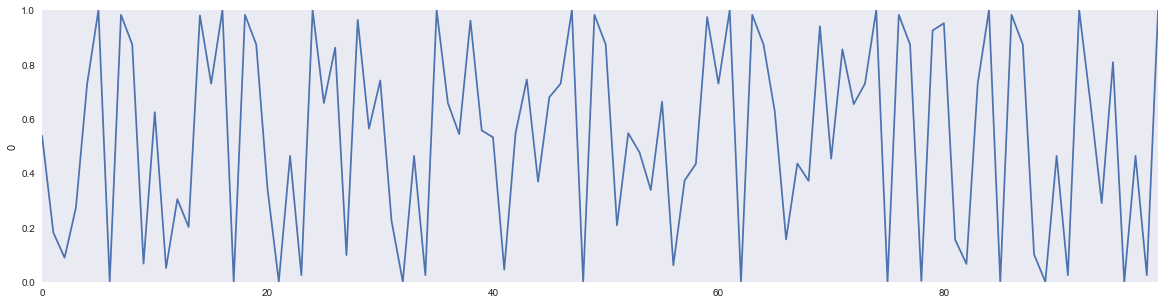

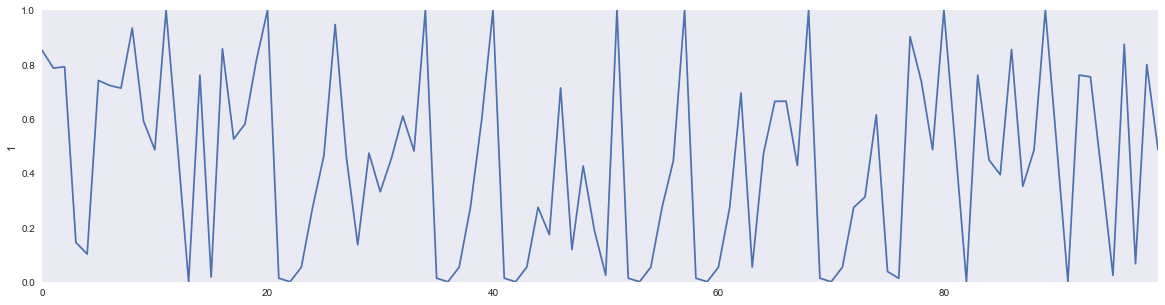

In [53]:
plot_sequences(df, label_names, max_rows, max_columns, row_offset, col_offset, ymin, ymax, plot_size)

# UCI data

In [26]:
# UCI labels
LABELS = [
    'WALKING',
    'WALKING_UPSTAIRS',
    'WALKING_DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING'
]

In [41]:
# Get UCI data ready
%run uci_har/download_dataset.py --output_dir=uci_har
%run uci_har/convert_to_csv.py --input_dir=uci_har --output_dir=uci_har --labels='[0,1,2,4]' --nb_samples=5000

# Convert UCI data to sequences
sequence_lenth=500
input_dir = 'uci_har'
parent_output_dir = 'uci_sequences'
base_names = ['inertial_signals', 'debug']
phases = ['train', 'test']

!rm -rf $parent_output_dir
print 'DELETED:', parent_output_dir

for base_name in base_names:
    for phase in phases:
        input_file = os.path.join(input_dir, '%s_%s.csv' %(base_name, phase))
        output_dir = os.path.join(parent_output_dir, base_name)
        cmd = 'convert_to_sequences.py -i %s -o %s -c %s' %(input_file, output_dir, sequence_lenth)
        print 'run cmd:', cmd
        %run $cmd

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

Train set size: 19996
Test set size: 19996
Files saved: ['uci_har/inertial_signals_train.csv', 'uci_har/inertial_signals_test.csv']
Debug files saved: ['uci_har/debug_train.csv', 'uci_har/debug_test.csv']
DELETED: uci_sequences
run cmd: convert_to_sequences.py -i uci_har/inertial_signals_train.csv -o uci_sequences/inertial_signals -c 500
Path to converted files: uci_sequences/inertial_signals/
run cmd: convert_to_sequences.py -i uci_har/inertial_signals_test.csv -o uci_sequences/inertial_signals -c 500
Path to converted files: uci_sequences/inertial_signals/
run cmd: convert_to_sequences.py -i uci_har/debug_train.csv -o uci_sequences/debug -c 500
Path to converted files: uci_sequences/debug/
run cmd: convert_to_sequences.py -i uci_har/debug_test.csv -o uci_sequences/debug -c 500
Path to converted files: uci_sequences/debug/


In [55]:
phase = 'TRAIN'
datasets_dir = "uci_sequences/inertial_signals"
dataset_name = 'body_acc_x'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))
df = load(input_csv_path)

label_names = LABELS
max_rows = 1
max_columns = None
row_offset = 0
col_offset = 0
ymin=-1
ymax=1
plot_size = 1

number of sequences: 34
number of sequences for label WALKING: 9
number of sequences for label WALKING_UPSTAIRS: 9
number of sequences for label WALKING_DOWNSTAIRS: 8
number of sequences for label STANDING: 8


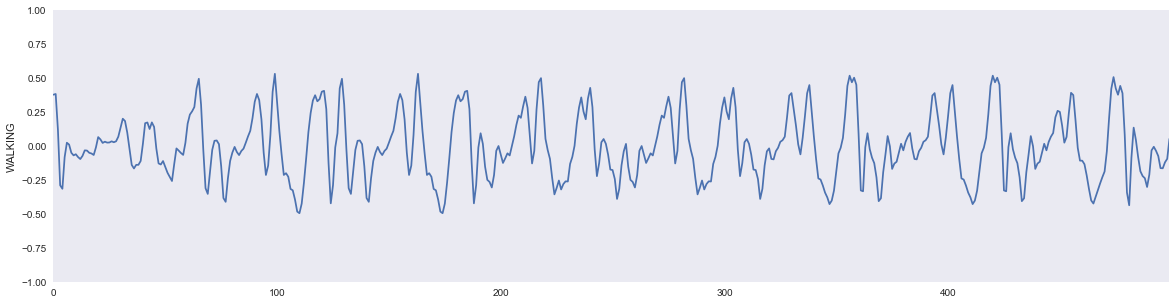

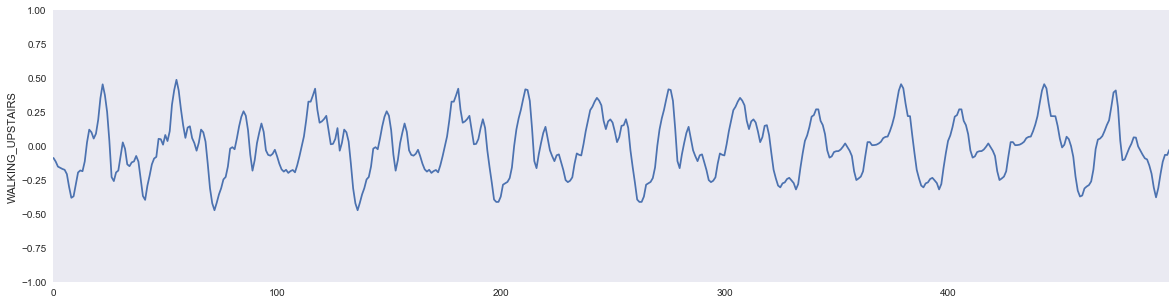

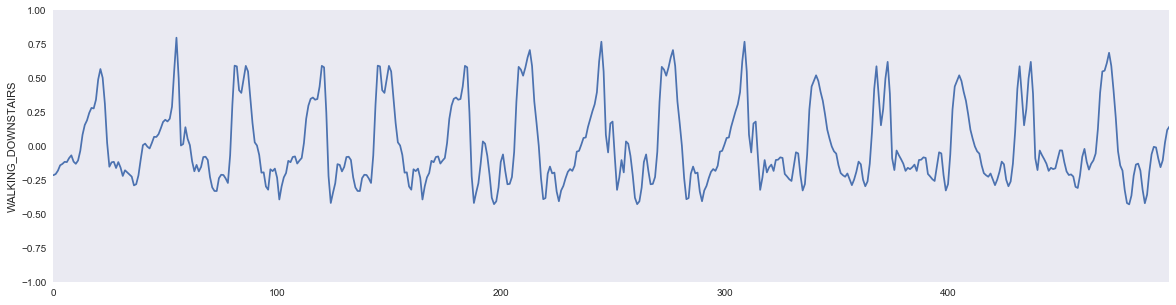

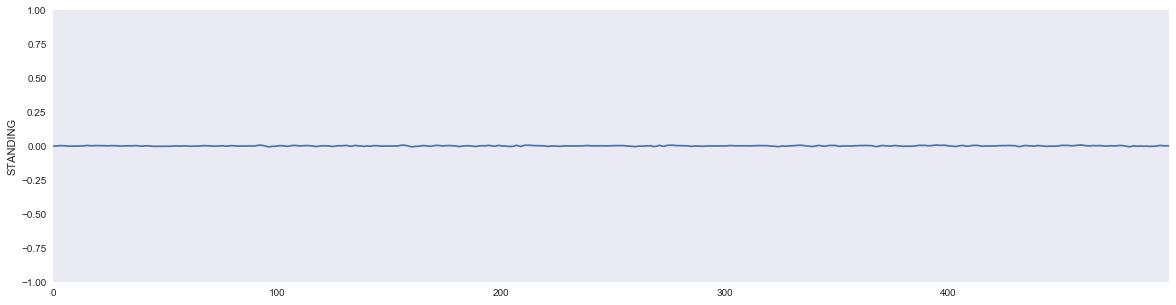

In [56]:
plot_sequences(df, label_names, max_rows, max_columns, row_offset, col_offset, ymin, ymax, plot_size)

# Artificial data

In [228]:
# generate artificial data
!cd artificial; python generate_artificial_data.py

# Convert artificial data
sequence_lenth=8
input_dir = 'artificial'
output_dir = 'artificial_sequences'

!rm -rf $parent_output_dir
print 'DELETED:', output_dir

input_file = os.path.join(input_dir, 'binary_ampl=10.0_mean=0.0_noise=1.0.csv')
cmd = 'convert_to_sequences.py -i %s -o %s -c %s' %(input_file, output_dir, sequence_lenth)
print 'run cmd:', cmd
%run $cmd

==> figure saved: /Users/mleborgne/_git/nupic.research/projects/capybara/datasets/artificial/binary_ampl=10.0_mean=0.0_noise=0.0.png
DELETED: artificial_sequences
run cmd: convert_to_sequences.py -i artificial/binary_ampl=10.0_mean=0.0_noise=1.0.csv -o artificial_sequences -c 8
csv_path: artificial/binary_ampl=10.0_mean=0.0_noise=1.0.csv
skip label: int
skip label: C
skip label: int
skip label: C
Path to converted files: artificial_sequences/


In [57]:
phase = 'ALL'
datasets_dir = "artificial_sequences"
dataset_name = 'y'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))
df = load(input_csv_path)

label_names = range(0,3) # 3 labels
max_rows = 2
max_columns = None
row_offset = 0
col_offset = 0
ymin=-2
ymax=12
plot_size = 1

number of sequences: 598
number of sequences for label 0: 99
number of sequences for label 1: 249
number of sequences for label 2: 250


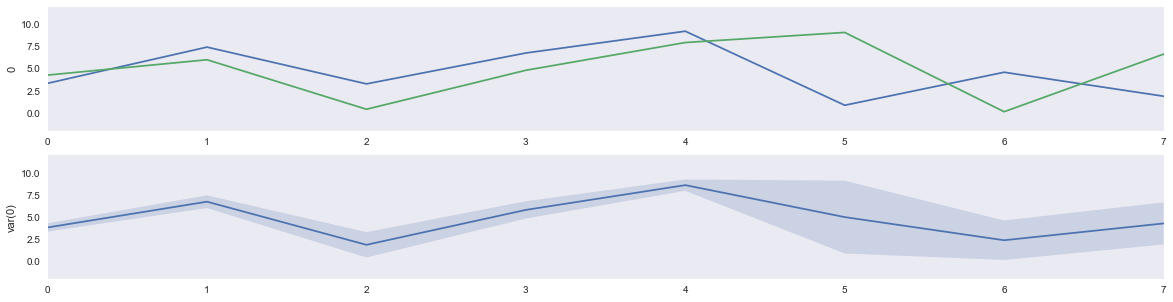

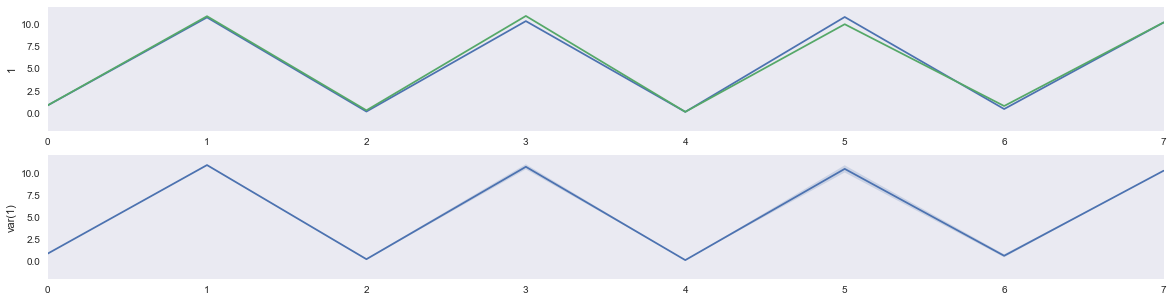

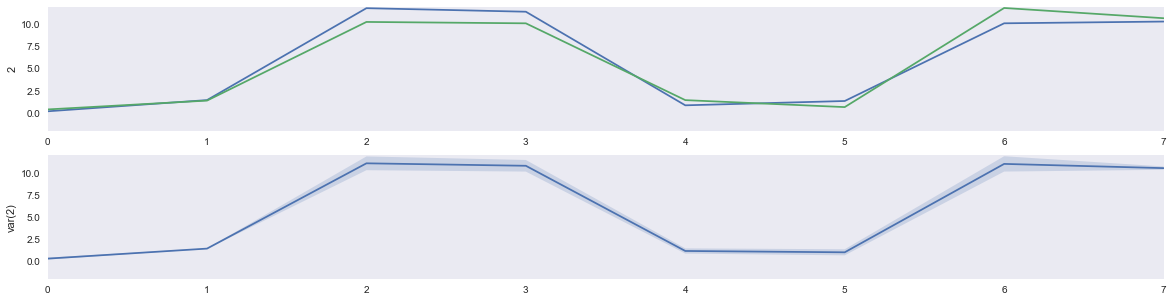

In [58]:
plot_sequences(df, label_names, max_rows, max_columns, row_offset, col_offset, ymin, ymax, plot_size)

# Sensortag data

In [223]:
# generate data
!cd sensortag; python convert_acc_data.py

# Convert data
sequence_lenth=100
input_dir = 'sensortag/converted'
output_dir = 'sensortag_sequences'

!rm -rf $parent_output_dir
print 'DELETED:', output_dir

input_file = os.path.join(input_dir, 'sensortag_x.csv')
cmd = 'convert_to_sequences.py -i %s -o %s -c %s' %(input_file, output_dir, sequence_lenth)
print 'run cmd:', cmd
%run $cmd

==> figure saved: converted/sensortag_x.png
==> figure saved: converted/sensortag_y.png
==> figure saved: converted/sensortag_z.png
DELETED: sensortag_sequences
run cmd: convert_to_sequences.py -i sensortag/converted/sensortag_x.csv -o sensortag_sequences -c 100
csv_path: sensortag/converted/sensortag_x.csv
skip label: int
skip label: C
skip label: int
skip label: C
Path to converted files: sensortag_sequences/


In [59]:
phase = 'ALL'
datasets_dir = "sensortag_sequences"
dataset_name = 'y'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))
df = load(input_csv_path)

label_names = range(0,8) # 7 labels
max_rows = 2
max_columns = None
row_offset = 0
col_offset = 0
ymin=-10
ymax=10
plot_size = 1

number of sequences: 96
number of sequences for label 1: 14
number of sequences for label 2: 14
number of sequences for label 3: 14
number of sequences for label 4: 15
number of sequences for label 5: 14
number of sequences for label 6: 13
number of sequences for label 7: 12


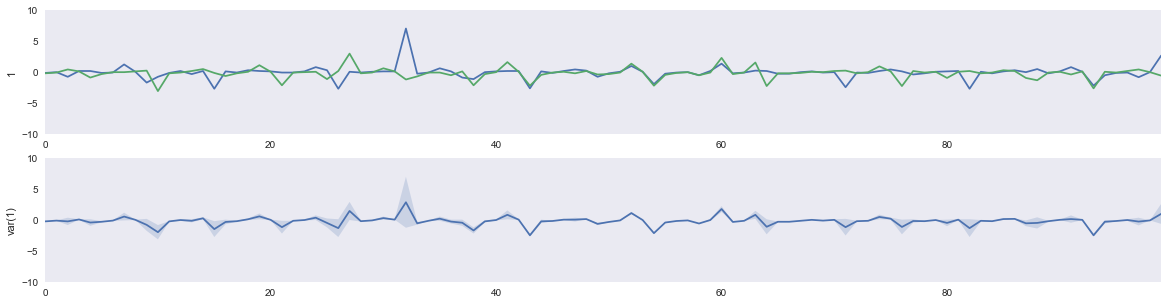

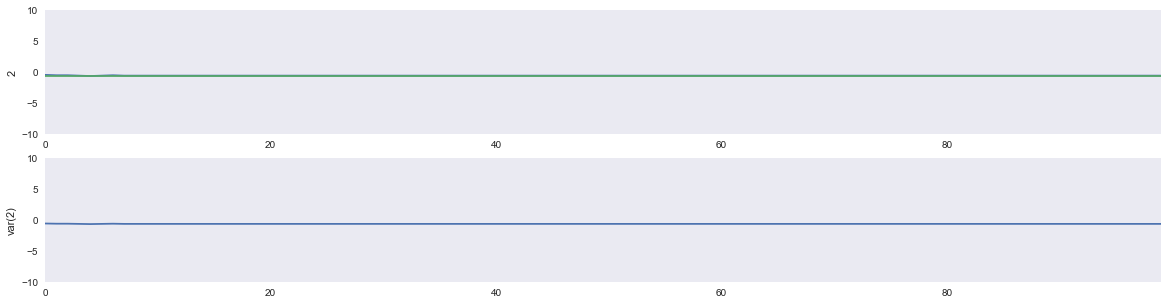

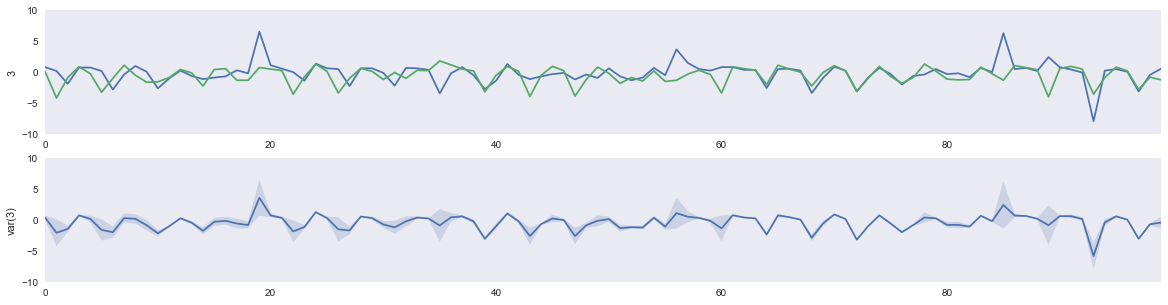

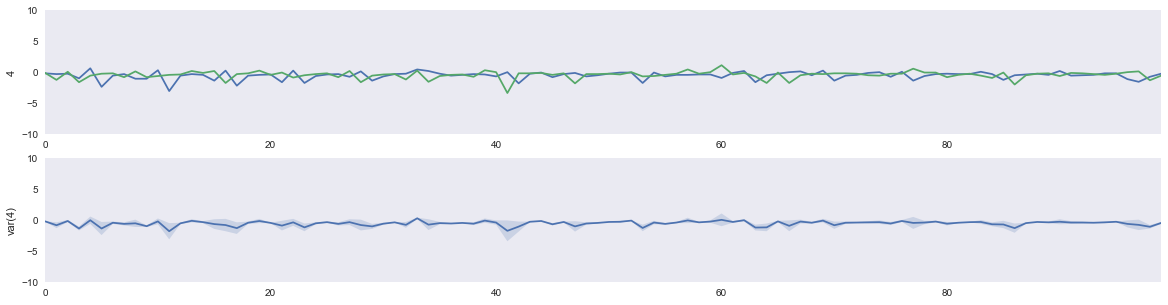

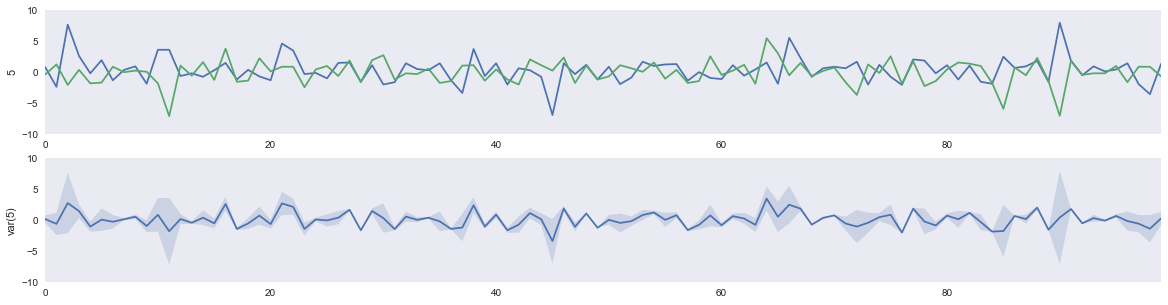

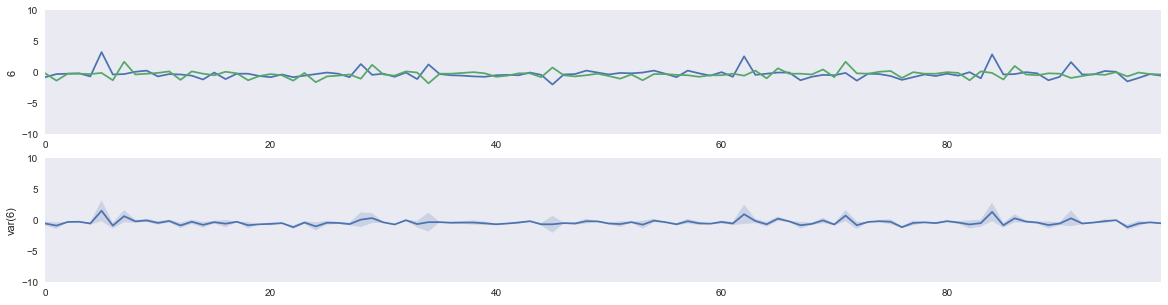

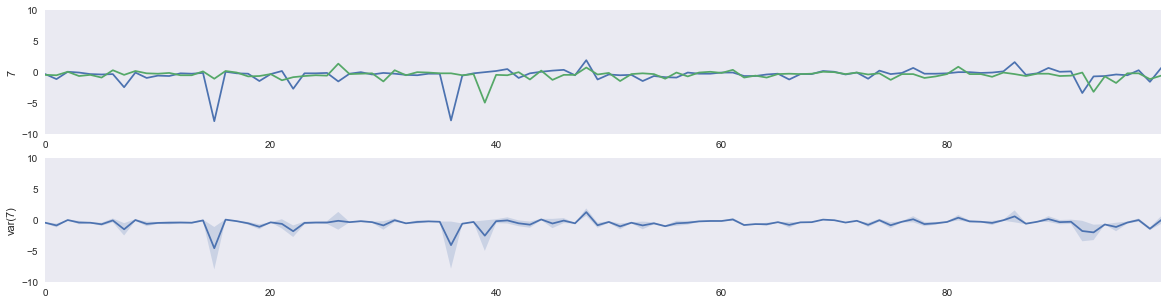

In [60]:
plot_sequences(df, label_names, max_rows, max_columns, row_offset, col_offset, ymin, ymax, plot_size)